In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import joblib
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load model
model_lstm = load_model("../models/saved/tsla_lstm_model.keras")

# Load and prepare data
df = pd.read_csv("../data/processed/TSLA_enriched.csv", parse_dates=["Date"], index_col="Date")
close_prices = df[['Close']].copy()

# Refit scaler to match what was used during training
scaler = MinMaxScaler()
close_scaled = scaler.fit_transform(close_prices)


In [4]:
# Set forecast horizon
future_days = 252  # ~12 months of trading days
window_size = 60

# Seed: last 60 days of known data
input_seq = close_scaled[-window_size:].reshape(1, window_size, 1)

# Collect predictions
future_preds_scaled = []

for _ in range(future_days):
    pred = model_lstm.predict(input_seq)[0][0]
    future_preds_scaled.append(pred)
    
    # Append new pred to sequence and remove oldest step
    input_seq = np.append(input_seq[:, 1:, :], [[[pred]]], axis=1)

# Inverse transform to get price predictions
future_preds = scaler.inverse_transform(np.array(future_preds_scaled).reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━

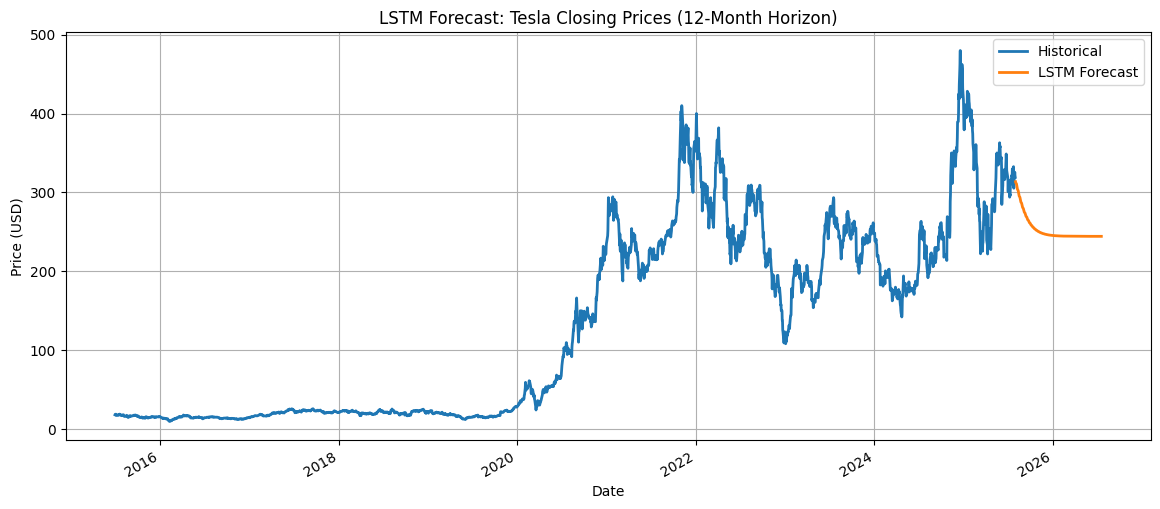

In [5]:
# Extend date range from last date
last_date = close_prices.index[-1]
future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=252)  # business days

# Create forecast DataFrame
future_df = pd.DataFrame({
    "Date": future_dates,
    "Forecast": future_preds.flatten()
}).set_index("Date")

# Combine with historical Close
combined = pd.concat([close_prices, future_df], axis=1)

# Plot
plt.figure(figsize=(14, 6))
combined["Close"].plot(label="Historical", linewidth=2)
combined["Forecast"].plot(label="LSTM Forecast", linewidth=2)
plt.title("LSTM Forecast: Tesla Closing Prices (12-Month Horizon)")
plt.ylabel("Price (USD)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()
